# Classifying Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2023
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 6: [Text Classification Algorithms](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch06.html#ch-classification) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Preparing Data for Machine Learning

### Load Data

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")

len(df)

24712

In [4]:
# set display column width unlimited to show full text
pd.set_option('max_colwidth', None)

df[['subreddit', 'title', 'text', 'lemmas', 'nouns', 'brands', 'models']].sample(5)

# reset display column width to 30
pd.reset_option('max_colwidth')

,subreddit,title,text,lemmas,nouns,brands,models
22478,motorcycles,Motorcycles in Florida,"Motorcycles in Florida: Hey friends! Is anyone from Florida here? I am concerned about bringing my motorcycle with me moving down there. I will be relocating to the Tampa area for work and when I just visited this past week I saw maybe a handful of motorcycles, what's with that? Is it out of season down there, is motorcycle insurance stupid expensive there, or are they really not that popular down there. I have a cbr 1000rr and one of my top priorities is getting a garage for her to keep her out of the elements along with security purposes. Just wanted to see if anyone could give me insight as I might have to sell the bike if it isn't a good idea to bring it with me.",motorcycle florida friend florida concerned bring motorcycle move relocate tampa area work visit this past week see handful motorcycle season motorcycle insurance stupid expensive be popular have cbr 1000rr one top priority get garage keep element security purpose want see give insight have sell bike be good idea bring,motorcycle florida friend florida motorcycle tampa area work this past week handful motorcycle season motorcycle insurance cbr 1000rr priority garage element security purpose insight bike idea,NaN,insight idea
11113,Toyota,2016 4Runner bumper mods,"2016 4Runner bumper mods: Not necessarily a mod but I was curious if I owned a 2016 base model with just standard features, would I be able to just swap over a 2020 4runner bumper onto the 2016? Would it be as simple to just bolt it right in?",2016 4runner bumper mod mod curious own 2016 base model standard feature be able swap 2020 4runner bumper 2016 be simple bolt,4runner bumper mod mod base model feature bumper,NaN,NaN
8368,Toyota,Exterior Accessories Online Store for 2003 Celica?,"Exterior Accessories Online Store for 2003 Celica?: Hi guys, I'm helping a friend look for exterior accessories for his 2003 celica, and I can't seem to find a good website which seems reputable. I personally have a WRX and the Subispeed.com website is usually my go to. The customer service is good, and it really doesn't strike you as a ""sketchy"" website at first glance. Any suggestions would be much appreciated!",exterior accessories online store 2003 celica guy help friend look exterior accessory 2003 celica seem find good website seem reputable have wrx subispeed.com website be go customer service good strike sketchy website first glance suggestion appreciate,exterior accessories online store celica guy friend accessory celica website wrx subispeed.com website customer service website glance suggestion,NaN,celica celica
10878,Audi,Weird engine sound,Weird engine sound: I am looking to buy my first audi but I am very unfamiliar with them as i have driven a Skoda all my life. I have found a suitable audi i like. Its an 2010 A4 1.8 TFSI (118kw) with 130000 km behind it. The thing that made me worry was the engine sound. Is that a healthy engine sound?,weird engine sound look buy first audi be unfamiliar drive skoda life find suitable audi like 2010 a4 1.8 tfsi 118kw 130000 km thing make worry engine sound healthy engine sound,engine sound audi skoda life audi a4 tfsi 118kw km thing engine sound engine sound,audi skoda audi,life a4
14686,motorcycles,Help,Help: I have a crf150f it was running fine then it started to bog down whenever I gave it throttle at first I thought it was the air filter so I installed a new one and the same thing still happened then I thought I had to clean my carb so I did that and it still does it Anybody know what is wrong with it,help have crf150f run start bog give throttle think air filter instal new one same thing happen think have clean carb do do know wrong,crf150f throttle air filter thing carb,NaN,NaN


### Define Label

Store the label in a variable to make modifications easier.

In [6]:
label = 'subreddit'

In [7]:
df[label].value_counts().to_frame()

,count
subreddit,
motorcycles,5654
AskMechanics,2713
teslamotors,2515
BMW,2303
Audi,2053
Honda,1957
Volkswagen,1657
Hyundai,1433
Toyota,1145


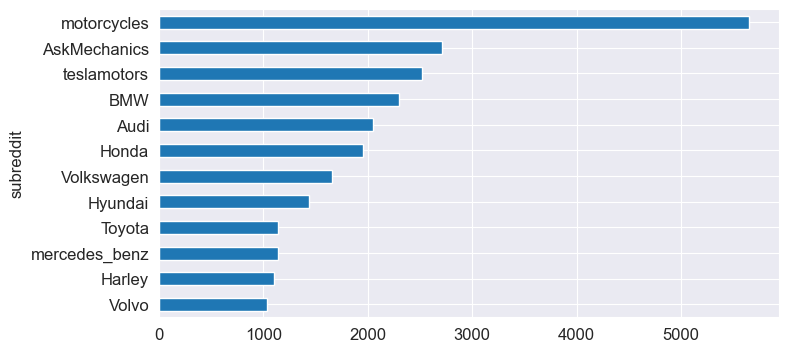

In [8]:
df[label].value_counts().plot(kind='barh').invert_yaxis()

### Convert to Huggingface Dataset

In [10]:
import datasets
from datasets import Dataset

data = Dataset.from_pandas(df[['text', label]])

In [21]:
data

Dataset({
    features: ['text', 'subreddit'],
    num_rows: 24712
})

### Subword-Tokenization

In [11]:
from transformers import AutoTokenizer

model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

In [12]:
text = "I love my BMW i3 but charging with my wallbox could be faster."
encoded_text = tokenizer(text)

encoded_text

{'input_ids': [101, 1045, 2293, 2026, 13154, 1045, 2509, 2021, 13003, 2007, 2026, 2813, 8758, 2071, 2022, 5514, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(*tokens)

[CLS] i love my bmw i ##3 but charging with my wall ##box could be faster . [SEP]


Tokens starting with `##` mark suffixes and should be merged with the preceding token to get the original string representation. The following function does just that:

In [14]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] i love my bmw i3 but charging with my wallbox could be faster. [SEP]'

#### Tokenizing the Whole Dataset

In [15]:
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, # pad examples with zeros to the right
                     truncation=True) # truncate to models maximum context size

In [22]:
tokenize(data[:2])

{'input_ids': [[101, 2393, 999, 6081, 12501, 2000, 15095, 1024, 2516, 2758, 2009, 2035, 1010, 18546, 12432, 24563, 2007, 6081, 2013, 1037, 6023, 4524, 2008, 2288, 2205, 2485, 1012, 1045, 1005, 2310, 2464, 2367, 15690, 2006, 2536, 21415, 1010, 2559, 2005, 2034, 11774, 3325, 1010, 2054, 1005, 1055, 2499, 2190, 2005, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2064, 1045, 3531, 2131, 2070, 2393, 6575, 3784, 2005, 1037, 2109, 2482, 2000, 4965, 1029, 1024, 1045, 2052, 2428, 9120, 2009, 1012, 1045, 2424, 2023, 3243, 10827, 1012, 2026, 3976, 2846, 2003, 1002, 11910, 1011, 20143, 1012, 1045, 2113, 2009, 1005, 1055, 2025, 2172, 2021, 1045, 1005, 1049, 372

In [29]:
# for tokenization use one single batch to ensure all tensors have the same shape
data_encoded = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

In [30]:
data_encoded

Dataset({
    features: ['text', 'subreddit', 'input_ids', 'attention_mask'],
    num_rows: 24712
})

### Extracting the Last Hidden States

In [31]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
text = ["this is a test", "this is not a test"]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
inputs['input_ids'].size()

torch.Size([2, 7])

In [26]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         ...,
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619],
         [ 0.0352, -0.3883,  0.0161,  ...,  0.0221,  0.0190,  0.4101]],

        [[-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475],
         [-0.2492, -0.5210, -0.0962,  ..., -0.2267,  0.3294,  0.3957],
         [-0.1805, -0.4085,  0.0953,  ..., -0.0257, -0.0198,  0.7817],
         ...,
         [-0.0915, -0.2593,  0.1829,  ..., -0.0708, -0.1404,  0.7053],
         [ 0.3783, -0.3699, -0.3622,  ..., -0.3398,  0.0264, -0.3225],
         [ 0.9101,  0.0807, -0.4004,  ...,  0.1511, -0.6977, -0.1923]]]), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

In [28]:
outputs.last_hidden_state[:,0]

tensor([[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
        [-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475]])

In [32]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return { "hidden_state": last_hidden_state[:,0].cpu().numpy() }

In [33]:
data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "subreddit"])

In [36]:
data_hidden = data_encoded.map(extract_hidden_states, batched=True, batch_size=1) # default is 1000

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

KeyboardInterrupt: 

### Vectorization

Here we use scikit-learn's TF-IDF vectorizers for bag-of-words vectorization, i.e. creating the TF or TF-IDF matrix.

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer

In [ ]:
# choose text column for vectorization
text_col = 'lemmas'

#### Term-Frequency Matrix (Counts)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# learn vocabulary for all data
count_vect = CountVectorizer(ngram_range=(1, 1), 
                             min_df=1, 
                             max_df=1.0, 
                             lowercase=True,
                             stop_words=None,
                             tokenizer=str.split)

# alternatively: only nouns or nouns+adjs+verbs
X_tf = count_vect.fit_transform(df[text_col])

type(X_tf)
X_tf.shape

Optional: Play with hyperparameters i.e.

  * `ngram_range=(1, 2)` to include bigrams
  * `max_df=0.5` to exclude words occuring in more than 50% of the documents
  * `min_df=2` to include only words occuring in at least 2 documents

#### TF-IDF-Matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vect = TfidfTransformer()

X_tfidf = tfidf_vect.fit_transform(X_tf)

X_tfidf.shape

### Train-Test-Split

Choose data matrix `X` and label vector `y` for training:

In [ ]:
# alternatively: X = X_tf
X = X_tfidf

# define label vector
y = df[label]

Now split with `train_test_split()`.

Recommendation: use `stratify=y`

In [ ]:
from sklearn.model_selection import train_test_split

# define holdout
test_size = 0.2

if test_size > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        stratify = y,
                                                        random_state=43
                                                       )
else:
    X_train, X_test, y_train, y_test = X, None, y, None
    
    
print("Trainigsmatrix:", X_train.shape)
print("Testmatrix:    ", X_test.shape)

Store information about train/test records in data frame.

In [ ]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [ ]:
df['train_test'].value_counts().to_frame()

Stratification enforces 80:20 split even within classes:

In [ ]:
df[[label, 'train_test']].pivot_table(index=label, columns='train_test', aggfunc=len, fill_value=0)

## Training and Evaluation


### Support Vector Machine

We use the Support Vector Machine for training which works excellent for TF-IDF vectors. Fastest implementation is `LinearSVC`, but allows only linear kernels. Alternatively use `SGDClassifier`.
To use a different classifier like logistic regression, just uncomment the respective lines.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

print(f'Training on column {label}')

clf = LinearSVC(C=1.0)
# clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

clf.fit(X_train, y_train);

print("Done.")

Extremely fast, right!?

### Evaluation

Apply classifier to test data with `predict()`.

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Not bad for a 12-class classifier!

$$Accuracy = \frac{\text{number of correctly classified data points}}{\text{all data points}}$$

In [ ]:
sum(y_test == y_test_pred)/len(y_test)

Looking at the per-class metrics with `classification_report`:

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

And on the training data:

In [ ]:
print("Classification Report")
print("=====================")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

### Confusion Matrix

Visualizing the `confusion_matrix` by `sns.heatmap`.

Not surprisingly, the generic category "AskMechanics" is frequently confused.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize=None) # or None
    fig, ax = plt.subplots(figsize=(6, 6))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
    
# label names - specifies order in confusion matrix
label_names = sorted(y_test.unique())

plot_confusion_matrix(y_test, y_test_pred, label_names)

### Checking misclassified Data

Looking at samples of misclassified and correctly classified data.

Add the predictions to the dataframe to simplify the analysis:

In [ ]:
# transform prediction vectors to pandas series with correct indexes
y_test_pred = pd.Series(y_test_pred, index=y_test.index)
y_train_pred = pd.Series(y_train_pred, index=y_train.index)

df['pred'] = pd.concat([y_test_pred, y_train_pred])

Check sample of misclassified data:

In [ ]:
# adjust size of visible columns
pd.set_option('max_colwidth', 3000)

df.query(f'train_test=="Test" and {label}!=pred')[[label, 'pred', 'text', text_col]].sample(5)

Check sample of correctly classified data:

In [ ]:
df.query(f'train_test=="Test" and {label}==pred')[[label, 'pred', 'text', text_col]].sample(5)

### Save DataFrame with Predictions

In [ ]:
df.to_csv("reddit-autos-selfposts-predicted.csv", sep=";", decimal=".", index=False)

## Explaining the Classifier

### Measuring Feature Importance

The coefficients of the SVM can be used to display the feature (=word) importance per class, positively and negatively.

In [ ]:
def plot_coefficients(classifier, vect, top_features=20):

    # get the feature names from the vectorizer
    feature_names = np.array(vect.get_feature_names_out())

    for i, category in enumerate(clf.classes_):

        # get class coefficients
        coef = classifier.coef_[i]

        # get the top and worst features
        top_pos_coefs = np.argsort(coef)[-top_features:]
        top_neg_coefs = np.argsort(coef)[:top_features]
        top_coefs = np.hstack([top_neg_coefs, top_pos_coefs])[::-1]

        # create plot
        plt.figure(figsize=(10, 5))
        plt.title(f'Coefficients for category "{category}"')
        colors = ['xkcd:green' if c > 0 else 'xkcd:red' for c in coef[top_coefs]]
        plt.bar(np.arange(2*top_features), coef[top_coefs], color=colors)

        feature_names[top_coefs]

        np.arange(0, 2 * top_features)

        plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefs], rotation=90, ha='center')
        plt.grid(linestyle='dashed')
        plt.tight_layout()
        plt.show()

In [ ]:
plot_coefficients(clf, count_vect)

### Classifier Explanation with LIME

We need a classifier with prediction probabilities. `LinearSVC` does not yield these. We use Logistic Regression instead.

In [ ]:
from sklearn.linear_model import SGDClassifier

print(f'Training on column {label}')

# log loss gives logistic regression
clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42)

clf.fit(X_train, y_train);

print("Done.")

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(count_vect, tfidf_vect, clf)

In [ ]:
# use lemmas only here, because model is trained on lemmas
samples = [
    "BMW great", 
    "Electric charge take long"
]

pred = pipeline.predict_proba(samples)
pred

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
columns = [f"Sample {i+1}" for i in range(pred.shape[0])]

pred_df = pd.DataFrame(pred.T, index=clf.classes_, columns=columns)
pred_df

In [ ]:
# adjust size of visible columns
pd.set_option('max_colwidth', 3000)

# df.query(f'train_test=="Test" and {label}!=pred')[[label, 'pred', 'text', text_col]].sample(5)

Example: Predicted is "teslamotors", but correct is "Toyota"

In [ ]:
df.iloc[7468].to_frame()

In [ ]:
text = df.iloc[7468]['lemmas']

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=clf.classes_)

exp = explainer.explain_instance(text, pipeline.predict_proba, num_features=6, top_labels=3)

print([exp.class_names[i] for i in exp.available_labels()])

In [ ]:
exp.show_in_notebook(text=False)